# Comparison of algorithms to correct NFI coordinates

[Example using ESA World Cover v200 2021](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200)

- 10 	: Tree cover
- 20 	: Shrubland
- 30 	: Grassland
- 40 	: Cropland
- 50 	: Built-up
- 60 	: Bare / sparse vegetation
- 70 	: Snow and ice
- 80 	: Permanent water bodies
- 90 	: Herbaceous wetland
- 95 	: Mangroves
- 100 : Moss and lichen

In [3]:
# Libraries
import imageio as io
import numpy as np
from collections import deque
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import geopandas as gpd

import rasterio
from rasterio import warp

%matplotlib inline

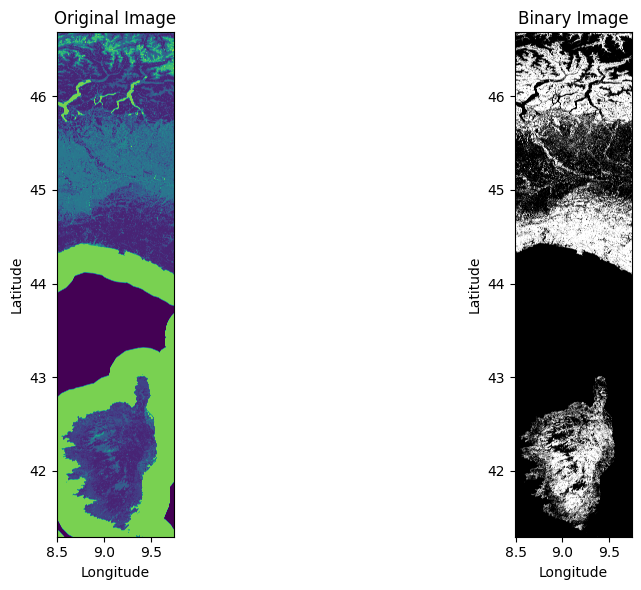

In [30]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# Load the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # Read the raster data
    image_org = src.read(1)  # Assuming you want to read the first band

    # Copy the original image for manipulation
    image_binary = image_org.copy()

    # Set all values that are not 10 to 0, and all that are 10 to 1
    image_binary[image_org != 10] = 0
    image_binary[image_org == 10] = 1

    # Plot the original and binary images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original raster
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    show(image_org, transform=src.transform, ax=ax[0], cmap="viridis")

    # Plot binary raster
    ax[1].set_title("Binary Image")
    ax[1].set_xlabel("Longitude")
    ax[1].set_ylabel("Latitude")
    show(image_binary, transform=src.transform, ax=ax[1], cmap="viridis")

    plt.tight_layout()
    plt.show()

In [133]:
# Open the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # Transform the raster to WGS84 format
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update(
        {
            "crs": "EPSG:4326",
            "transform": transform,
            "width": width,
            "height": height,
        }
    )

    # Read the raster data
    image_org = src.read(
        1,
        out_shape=(src.height, src.width),
        resampling=rasterio.enums.Resampling.bilinear,
    )

image_org

# Turn original image into a binary image
image_binary = image_org.copy()
forest_code = [10]
image_binary[~np.isin(image_binary, forest_code)] = 0  # Set all non-forest pixels to 0
image_binary[np.isin(image_binary, forest_code)] = 1  # Set all forest pixels to 1

# Display both images
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

ax[0].imshow(image_org, extent=warp.transform_bounds(src.crs, "EPSG:4326", *src.bounds))
ax[0].set_title("Original image")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_aspect(5)

ax[1].imshow(
    image_binary, extent=warp.transform_bounds(src.crs, "EPSG:4326", *src.bounds)
)
ax[1].set_title("Binary image")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_aspect(5)

plt.show()

array([[60, 60, 60, ..., 30, 30, 30],
       [60, 60, 60, ..., 30, 30, 30],
       [60, 60, 60, ..., 30, 30, 30],
       ...,
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80]], dtype=uint8)

In [40]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt

# Inputs
seed_random_point = 1999  # Set random seed
middle_point_radius = 70  # Set pixel radius around middle point
n_window = 5  # Size of the window to calculate forest density

In [2]:
# Function to produce a raster with forest density
def produce_raster_with_forest_density(input_image, n_window):
    
    # Initialize an empty image
    out_image = np.zeros_like(input_image)

    # Loop over each pixel in the reduced image
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            # If the pixel is at the border, that is within the pixels defined by n_window, return a 0
            if (
                i < n_window // 2
                or i >= input_image.shape[0] - n_window // 2
                or j < n_window // 2
                or j >= input_image.shape[1] - n_window // 2
            ):
                out_image[i, j] = 0
            # If the pixel's value in input_image is 0, return 0
            elif input_image[i, j] == 0:
                out_image[i, j] = 0
            # If the pixel is not close to the border and has value 1, then calculate the sum of pixels around it within a n_window times n_window window
            else:
                window = input_image[
                    i - n_window // 2 : i + n_window // 2 + 1,
                    j - n_window // 2 : j + n_window // 2 + 1,
                ]
                out_image[i, j] = np.sum(window)

    return out_image

In [3]:
# Function to zero out a circular area in the raster
def zero_out_circle(image, center_point, radius_in_meters, pixel_size):
    """
    Zero out a circular area in a raster image.

    Parameters:
    image: numpy.ndarray - The raster image to modify.
    center_point: tuple - The (row, col) index of the center point in the image.
    radius_in_meters: int - The radius of the circle to zero out in meters.
    pixel_size: int - The size of one pixel in meters.

    Returns:
    numpy.ndarray - The modified raster image with the circular area zeroed out.
    """
    radius_in_pixels = radius_in_meters // pixel_size

    # Create a binary mask where pixels within the radius will be True
    mask = np.zeros_like(image, dtype=bool)

    # Create an array with the indices of the pixels
    rows, cols = np.indices(image.shape)

    # Calculate the distance of all pixels to the middle point
    distances = np.sqrt((rows - center_point[0]) ** 2 + (cols - center_point[1]) ** 2)

    # Set True in the mask for pixels within the radius
    mask[distances >= radius_in_pixels] = True

    # Set the values to zero in the original image where the mask is True
    image[mask] = 0

    return image

In [22]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


def extract_nonzero_pixels_to_dataframe(image, transform):
    """
    Extract non-zero pixels from a raster image and return a DataFrame with latitude,
    longitude, and value.

    Parameters:
    image: numpy.ndarray - The raster image to process.
    transform: affine.Affine - The affine transform associated with the raster image.

    Returns:
    DataFrame - A DataFrame with columns for latitude, longitude, and the pixel value.
    """
    # Find indices of all non-zero pixels
    rows, cols = np.nonzero(image)

    # Convert pixel positions to spatial coordinates
    coords = [
        rasterio.transform.xy(transform, row, col, offset="center")
        for row, col in zip(rows, cols)
    ]

    # Extract the values of the non-zero pixels
    values = image[rows, cols]

    # Create a DataFrame
    df = pd.DataFrame(
        {
            "Longitude": [coord[0] for coord in coords],
            "Latitude": [coord[1] for coord in coords],
            "Value": values,
        }
    )

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    return gdf

In [27]:
from collections import deque
import numpy as np
import rasterio
import warnings


def bfs_closest_pixel(center_point, image, target_value):
    """
    Perform a BFS to find the closest pixel with the target_value to center_point.

    Parameters:
    center_point: tuple - The (row, col) index of the center point relative to the image.
    image: numpy.ndarray - The raster image to search within.
    target_value: int - The pixel value to search for.

    Returns:
    tuple - The (row, col) index of the closest pixel with the target_value, or the original center_point if not found.
    """
    # Quick check if the target_value is in the raster file forest_density_mask
    if target_value not in image:
        warnings.warn(
            f"Value {target_value} not found in the raster. Using the max value instead."
        )
        target_value = np.max(image)

    # Initialize BFS
    rows, cols = image.shape
    visited = np.zeros((rows, cols), dtype=bool)
    queue = deque([center_point])

    # Directions for exploring neighbors: up, down, left, right
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        current_point = queue.popleft()
        current_row, current_col = current_point

        # Check if we found the target_value
        if image[current_row, current_col] == target_value:
            return current_point  # Return the coordinates of the found pixel

        # Mark the current point as visited
        visited[current_row, current_col] = True

        # Explore neighbors
        for dr, dc in directions:
            neighbor_row, neighbor_col = current_row + dr, current_col + dc
            if (
                0 <= neighbor_row < rows
                and 0 <= neighbor_col < cols
                and not visited[neighbor_row, neighbor_col]
            ):
                queue.append((neighbor_row, neighbor_col))

    # If we reach this point, no pixel with the target_value was found
    warnings.warn(
        "No closest point found with the desired value. Returning the center point."
    )
    return center_point

In [36]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt

# Inputs
seed_random_point = 2002  # Set random seed. Good ones: 1998
middle_point_radius_pixels = 70  # Radius in pixels
radius_in_meters = 700  # Radius in meters for zeroing
pixel_size = 10  # Pixel size in meters (one pixel represents 10 meters)
n_window = 5  # nxn kernel to calculate forest density around forest pixel


# Load the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # -----------------------------------------------------------
    # Set middle point of window
    # TODO Replace this, if you want to use a specific point from NFI data
    # Get coordinates for a random point in the image
    np.random.seed(seed_random_point)
    random_row = np.random.randint(
        middle_point_radius_pixels, src.height - middle_point_radius_pixels
    )
    random_col = np.random.randint(
        middle_point_radius_pixels, src.width - middle_point_radius_pixels
    )
    middle_point = (random_row, random_col)
    coord_id = "random"  # TODO: Adjust for site id from NFI data

    # print(middle_point)

    # -----------------------------------------------------------
    # Crop to window
    # Set the additional pixels to expand the window in each direction
    buffer_pixels = min(5, n_window + 5)

    # Calculate the bounds of the window with additional buffer
    row_start = max(0, middle_point[0] - middle_point_radius_pixels - buffer_pixels)
    col_start = max(0, middle_point[1] - middle_point_radius_pixels - buffer_pixels)
    window_width = middle_point_radius_pixels * 2 + buffer_pixels * 2
    window_height = middle_point_radius_pixels * 2 + buffer_pixels * 2

    # Ensure the window does not exceed the image dimensions
    row_end = min(row_start + window_height, src.height)
    col_end = min(col_start + window_width, src.width)

    # Adjust the start if the end is being clipped due to image boundary
    row_start = max(0, row_end - window_height)
    col_start = max(0, col_end - window_width)

    window = Window(
        col_off=col_start,
        row_off=row_start,
        width=window_width,
        height=window_height,
    )

    # -----------------------------------------------------------
    # Read the data from the window
    window_transform = src.window_transform(window)
    image_org_window = src.read(1, window=window)

    # The center point coordinates must be recalculated since the window has been buffered
    center_row = middle_point[0] - row_start
    center_col = middle_point[1] - col_start
    center_point_relative = (center_row, center_col)

    # Create a binary image based on the condition
    image_binary_window = image_org_window.copy()
    image_binary_window = np.where(image_org_window == 10, 1, 0)

    # Apply forest density map to binary image
    forest_density_mask = image_binary_window.copy()
    forest_density_mask = produce_raster_with_forest_density(
        image_binary_window, n_window
    )

    # Now you can call the zero_out_circle function with the adjusted center point
    forest_density_mask_circled = forest_density_mask.copy()
    forest_density_mask_circled = zero_out_circle(
        forest_density_mask_circled, center_point_relative, radius_in_meters, pixel_size
    )

    # -----------------------------------------------------------
    # Extract forest coordinates based on desired method
    # Export forest_density geo dataframe
    forest_density_gdf = extract_nonzero_pixels_to_dataframe(
        forest_density_mask_circled, window_transform
    )

    display(forest_density_gdf)

    forest_density_gdf.to_file(
        "forest_density_site_" + coord_id + " .geojson", driver="GeoJSON"
    )

    # Get closes pixel to center point
    closest_forest_pixel = bfs_closest_pixel(
        center_point_relative, forest_density_mask_circled, target_value=5
    )
    print(clostest_forest_pixel)
    # -----------------------------------------------------------
    # Create plots

    # Plot the original, binary, and forest density images side by side
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))

    # Plot original raster
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    show(image_org_window, transform=window_transform, ax=ax[0], cmap="viridis")

    # Plot binary raster
    ax[1].set_title("Binary Forest Mask")
    ax[1].set_xlabel("Longitude")
    ax[1].set_ylabel("Latitude")
    show(image_binary_window, transform=window_transform, ax=ax[1], cmap="viridis")

    # Plot forest mask
    ax[2].set_title("Forest Density Mask")
    ax[2].set_xlabel("Longitude")
    ax[2].set_ylabel("Latitude")
    show(forest_density_mask, transform=window_transform, ax=ax[2], cmap="viridis")

    # Plot circled-out forest mask
    ax[3].set_title("Circled-out Forest Density Mask")
    ax[3].set_xlabel("Longitude")
    ax[3].set_ylabel("Latitude")
    show(
        forest_density_mask_circled,
        transform=window_transform,
        ax=ax[3],
        cmap="viridis",
    )

,Longitude,Latitude,Value,geometry
0,8.904700,45.435280,9,POINT (8.90470 45.43528)
1,8.904790,45.435280,10,POINT (8.90479 45.43528)
2,8.904700,45.435190,14,POINT (8.90470 45.43519)
3,8.904790,45.435190,15,POINT (8.90479 45.43519)
4,8.904880,45.435190,15,POINT (8.90488 45.43519)
...,...,...,...,...
5770,8.903802,45.422883,14,POINT (8.90380 45.42288)
5771,8.903891,45.422883,13,POINT (8.90389 45.42288)
5772,8.903981,45.422883,13,POINT (8.90398 45.42288)
5773,8.904071,45.422883,12,POINT (8.90407 45.42288)


KeyboardInterrupt: 

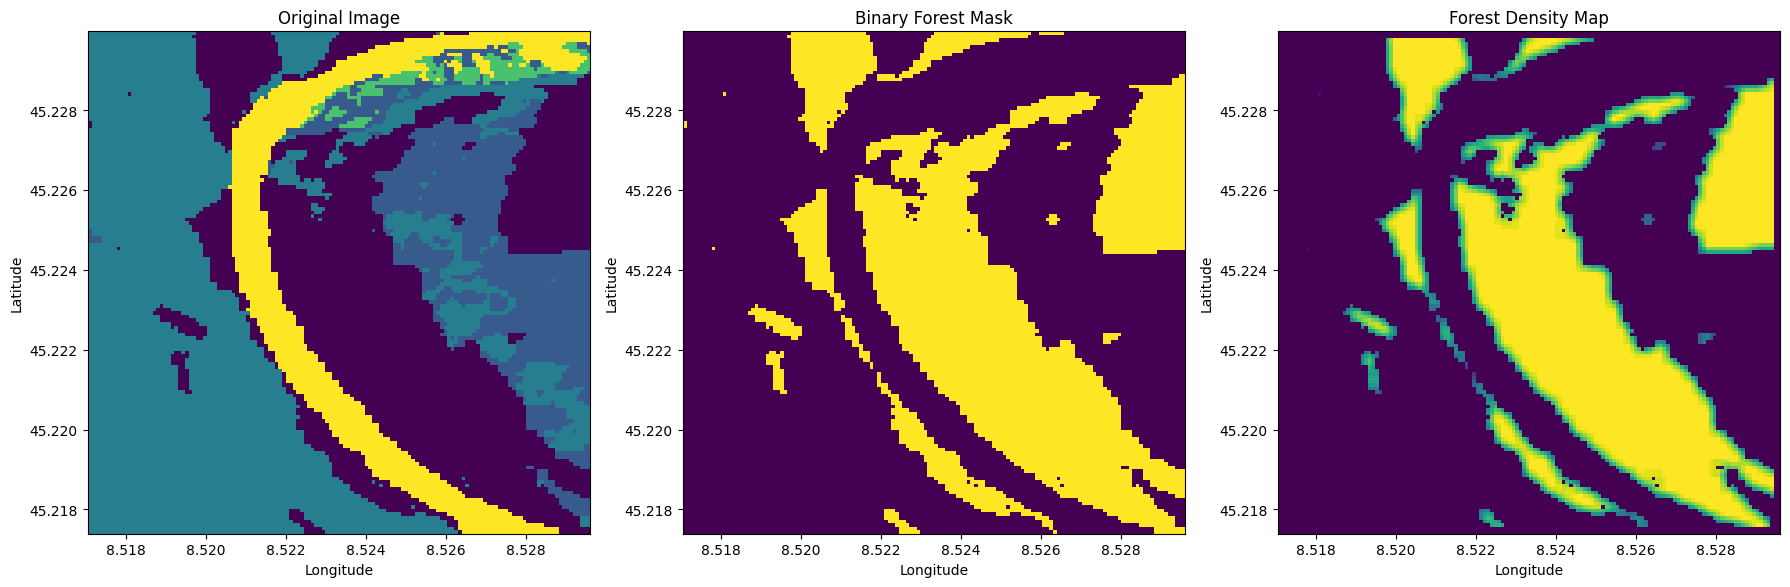

In [62]:
# Load the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # Pick a random point in that image
    np.random.seed(seed_random_point)
    middle_point = (
        np.random.randint(middle_point_radius, src.width - middle_point_radius),
        np.random.randint(middle_point_radius, src.height - middle_point_radius),
    )

    # Calculate the bounds of the window
    row_start = max(0, middle_point[1] - middle_point_radius)
    col_start = max(0, middle_point[0] - middle_point_radius)
    window = Window(
        col_off=col_start,
        row_off=row_start,
        width=middle_point_radius * 2,
        height=middle_point_radius * 2,
    )

    # Read the data from the window
    window_transform = src.window_transform(window)
    image_org_window = src.read(1, window=window)

    # Create a binary image based on the condition
    image_binary_window = np.where(image_org_window == 10, 1, 0)

    # Create the forest density map
    forest_density_map = produce_raster_with_forest_density(
        image_binary_window, n_window
    )

    # forest_density_map = zero_out_circle(forest_density_map, middle_point, 700, 10)

    # Plot the original, binary, and forest density images side by side
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the number of subplots to 3

    # Plot original raster
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    show(image_org_window, transform=window_transform, ax=ax[0], cmap="viridis")

    # Plot binary raster
    ax[1].set_title("Binary Forest Mask")
    ax[1].set_xlabel("Longitude")
    ax[1].set_ylabel("Latitude")
    show(image_binary_window, transform=window_transform, ax=ax[1], cmap="viridis")

    # Plot forest density map
    ax[2].set_title("Forest Density Map")
    ax[2].set_xlabel("Longitude")
    ax[2].set_ylabel("Latitude")
    show(forest_density_map, transform=window_transform, ax=ax[2], cmap="viridis")

    plt.tight_layout()
    plt.show()

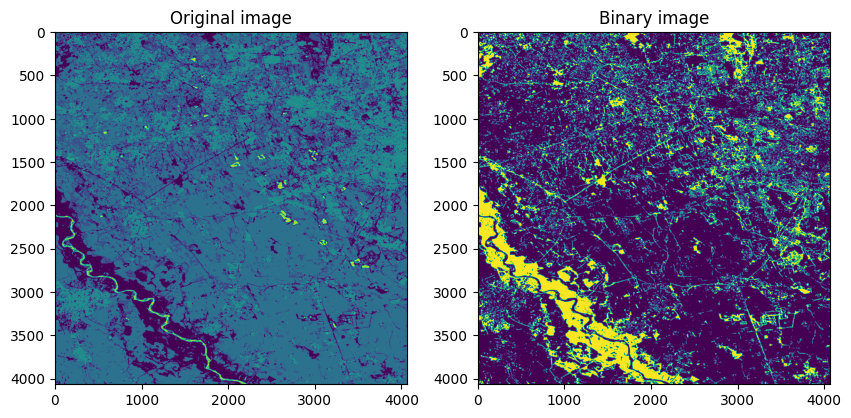

In [5]:
# Inputs
seed_random_point = 12  # Set random seed
middle_point_radius = 2023  # Set pixel radius around middle point

# Pick a random point in that image
np.random.seed(seed_random_point)
middle_point = (
    np.random.randint(0, image_binary.shape[0]),
    np.random.randint(0, image_binary.shape[1]),
)


# Reduce image to a square around the middle point with a given radius plus a buffer
def reduce_image_to_aoi(point_xy, radius, image, buffer):
    image_out = image[
        point_xy[0] - radius - buffer : point_xy[0] + radius + buffer,
        point_xy[1] - radius - buffer : point_xy[1] + radius + buffer,
    ]

    return image_out


image_org_reduced = reduce_image_to_aoi(
    middle_point, middle_point_radius, image_org, 10
)
image_bin_reduced = reduce_image_to_aoi(
    middle_point, middle_point_radius, image_binary, 10
)

# Display both images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_org_reduced)
ax[0].set_title("Original image")
ax[1].imshow(image_bin_reduced)
ax[1].set_title("Binary image")
plt.show()

In [ ]:
def display_original_and_new_coordinate(old_coordinate_xy, ):

## Extract closes Forest Pixel from given Coordinate (NOT WORKING YET)

This approach extracts the closest forest pixel from a given coordinate. It does a BFS search and prefers pixels that have 8 neighboring forest pixels, or takes the pixel that has the most neighboring forest pixels if there are none with 8. Else, it takes the closest forest pixel.

In [3]:
import imageio
import numpy as np
from collections import deque
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


def find_closest_forest_pixel(
    image_path, uncertainty_radius, seed_random_point, forest_number=111
):
    # Load tif file
    image = imageio.imread(image_path)

    # Replace all different types of forests with the same value
    forest_code = [111, 114, 115, 116, 121, 124, 125, 126, 200]
    image[np.isin(image, forest_code)] = forest_number

    # Set seed for reproducibility
    np.random.seed(seed_random_point)

    # Generate random x and y coordinates within the range of the uncertainty radius
    # x, y = np.random.randint(uncertainty_radius, size=2)
    np.random.seed(seed_random_point)
    x = np.random.randint(0, image.shape[1])
    y = np.random.randint(0, image.shape[0])

    # Define the search radius in pixels
    search_radius = int(uncertainty_radius)

    # Define the maximum number of pixels to search
    search_n_pixels = 1000000

    # Define the directions for the 8 neighboring pixels
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Define the visited array
    visited = np.zeros_like(image, dtype=bool)

    # Define the queue
    queue = deque([(x, y, 0)])

    # Define the closest pixel and its number of neighbors
    closest_pixel = None
    closest_neighbors = 0

    # Define the pixels with 8 adjacent pixels with value forest_number
    perfect_pixels = []

    # Define the pixels with the highest number of neighbors
    best_pixels = []

    # Define the number of pixels searched
    n_pixels_searched = 0

    # Perform the bfs search
    while queue and n_pixels_searched < search_n_pixels:
        x, y, distance = queue.popleft()

        # If the pixel has the value forest_number, check its neighbors
        if image[x, y] == forest_number:
            # print(x, y, image[x, y])

            pixel_neighbors = []
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if (
                    0 <= nx < image.shape[0]
                    and 0 <= ny < image.shape[1]
                    and image[nx, ny] == forest_number
                ):
                    pixel_neighbors.append((nx, ny))
            if len(pixel_neighbors) == 8:
                perfect_pixels.append((x, y, len(pixel_neighbors)))
            elif len(pixel_neighbors) > closest_neighbors:
                closest_pixel = (x, y)
                closest_neighbors = len(pixel_neighbors)
                best_pixels = [(x, y, len(pixel_neighbors))]
            elif len(pixel_neighbors) == closest_neighbors:
                best_pixels.append((x, y, len(pixel_neighbors)))

        # If the maximum radius is reached, continue with the next pixel
        if distance == search_radius:
            continue

        # Mark the pixel as visited
        visited[x, y] = True

        # Add the neighboring pixels to the queue
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if (
                0 <= nx < image.shape[0]
                and 0 <= ny < image.shape[1]
                and not visited[nx, ny]
            ):
                queue.append((nx, ny, distance + 1))

        # Increment the number of pixels searched
        n_pixels_searched += 1

    # If no pixel with 8 adjacent pixels with value forest_number is found, use the closest pixel
    print(perfect_pixels)
    print(best_pixels)

    if perfect_pixels:
        closest_pixel = sorted(perfect_pixels, key=lambda x: x[2], reverse=True)[0][:2]
    elif not closest_pixel and best_pixels:
        closest_pixel = sorted(best_pixels, key=lambda x: x[2], reverse=True)[0][:2]

    # If no pixel with value forest_number is found, return None
    if not closest_pixel:
        print(
            "No pixel with value forest_number found within search area. Returning original coordinates."
        )
        closest_pixel = (x, y)

    print(closest_pixel)

    # Create the plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first figure
    im = axs[0].imshow(image)

    # Plot the point as a red cross
    axs[0].plot(x, y, "rx", markersize=10)

    # Plot the most forested pixel as a red star
    axs[0].plot(
        closest_pixel[0],
        closest_pixel[1],
        "r*",
        markersize=10,
    )

    # Draw a circle around the point
    circle = Circle(
        (x, y),
        radius=uncertainty_radius,
        fill=False,
        color="r",
    )
    axs[0].add_patch(circle)

    # Set the limits of the x and y axes to be slightly larger than the circle's bounding box
    left, right = max(0, x - uncertainty_radius - 10), min(
        image.shape[1], x + uncertainty_radius + 10
    )
    bottom, top = max(0, y - uncertainty_radius - 10), min(
        image.shape[0], y + uncertainty_radius + 10
    )
    axs[0].set_xlim(left, right)
    axs[0].set_ylim(bottom, top)

    # Add colorbar
    sm = ScalarMappable(cmap=im.get_cmap(), norm=im.norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[0])

    # Plot the second figure
    im = axs[1].imshow(image)

    # Plot the point as a red cross
    axs[1].plot(x, y, "rx", markersize=10)

    # Plot the most forested pixel as a red star
    axs[1].plot(
        closest_pixel[0],
        closest_pixel[1],
        "r*",
        markersize=10,
    )

    # Draw a circle around the point
    circle = Circle(
        (x, y),
        radius=uncertainty_radius,
        fill=False,
        color="r",
    )
    axs[1].add_patch(circle)

    # Set the limits of the x and y axes to be slightly larger than the circle's bounding box
    left, right = max(0, x - uncertainty_radius - 10), min(
        image.shape[1], x + uncertainty_radius + 10
    )
    bottom, top = max(0, y - uncertainty_radius - 10), min(
        image.shape[0], y + uncertainty_radius + 10
    )
    axs[1].set_xlim(x - 10, x + 10)
    axs[1].set_ylim(y - 10, y + 10)

    # Add colorbar
    sm = ScalarMappable(cmap=im.get_cmap(), norm=im.norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axs[1])

    # Show the plot
    plt.show()

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_16418/1989485487.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


[(862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (862, 397, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389, 8), (857, 389

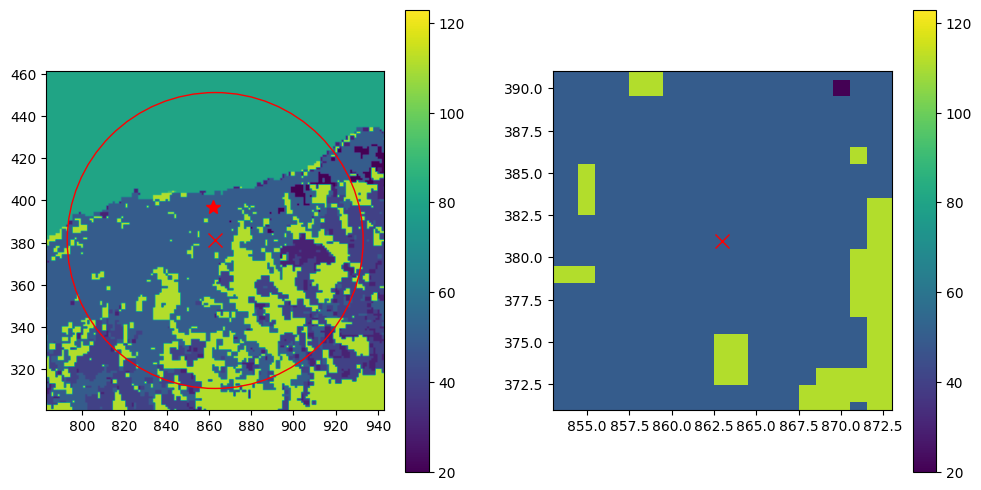

In [4]:
# INPUTS TO SPECIFY
image_path = "example_for_coord_search.tif"  # Example from COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019 with 100m resolution
uncertainty_radius = (
    70  # For S2 1 pixel = 10m, so taking 70 pixels = 700m. 700^2 * pi = 1540 pixels
)
seed_random_point = 2020
seed_similarly_forested_point = 1111

# RUN FUNCTION
find_closest_forest_pixel(
    image_path=image_path,
    uncertainty_radius=uncertainty_radius,
    seed_random_point=seed_random_point,
)

## Pick "deepest" forest pixel within uncertainty radius

This approach first calculates for every pixel within the given coordinates uncertainty radius, how many neighboring forest pixels there are (can be specified with another radius).
Then, the pixel with the highest number of neighboring forest pixels is chosen as the new coordinate. 
If there are multiple pixels with the same forest density (amount of neighboring forest pixels), one of them is chosen randomly.

In [1]:
def count_pixels_within_radius(
    image, middle_point, pixel_radius, target_value, inner_radius=10
):
    """
    This function takes an image, a middle_point, a pixel_radius, a target_value, and an inner_radius as input.
    It returns a dataframe with the coordinates of each pixel and the number of pixels with the same value in the inner_radius.
    """
    # Create an empty list to store the results
    results = []

    # Loop over all pixels within the pixel_radius
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            distance = np.sqrt((i - middle_point[0]) ** 2 + (j - middle_point[1]) ** 2)
            if distance <= pixel_radius:
                # Count the number of pixels with the same value in the inner_radius
                count = 0
                for k in range(i - inner_radius, i + inner_radius + 1):
                    for l in range(j - inner_radius, j + inner_radius + 1):
                        if (
                            k >= 0
                            and k < image.shape[0]
                            and l >= 0
                            and l < image.shape[1]
                            and np.sqrt((k - i) ** 2 + (l - j) ** 2) <= inner_radius
                            and image[k, l] == target_value
                        ):
                            count += 1
                # Append the result to the list
                results.append((i, j, count))

    # Convert the list to a pandas dataframe
    df = pd.DataFrame(results, columns=["x", "y", "count"])

    return df

In [2]:
def new_coord_based_on_forest_density(
    image_path,
    uncertainty_radius,
    inner_radius,
    seed_random_point,
    seed_similarly_forested_point,
    forest_number = 111
):
    # Load the image
    image = imageio.imread(image_path)

    # Replace all different types of forests with the same value
    forest_code = [111, 114, 115, 116, 121, 124, 125, 126, 200]
    forest_number = 111
    image[np.isin(image, forest_code)] = forest_number

    # generate random x and y coordinates within the range of the image dimensions
    np.random.seed(seed_random_point)
    rand_x = np.random.randint(0, image.shape[1])
    rand_y = np.random.randint(0, image.shape[0])
    point = (rand_y, rand_x)

    # Calculate forest pixels within the radius, using an inner radius
    most_forested_pixel_raw = count_pixels_within_radius(
        image, point, uncertainty_radius, forest_number, inner_radius=inner_radius
    )

    most_forested_pixel_raw = most_forested_pixel_raw.sort_values(
        by="count", ascending=False
    )
    # Reduce dataframe to hold only the pixels with the highest number of forest pixels within the inner radius
    display(most_forested_pixel_raw.shape)
    most_forested_pixel = most_forested_pixel_raw.copy()

    most_forested_pixel = most_forested_pixel[
        most_forested_pixel["count"] == most_forested_pixel["count"].max()
    ]
    
    count_max = most_forested_pixel["count"].max()

    # If more than one pixel has highest count, then choose one randomly
    if len(most_forested_pixel) > 1:
        most_forested_pixel = most_forested_pixel.sample(
            n=1, random_state=np.random.seed(seed_similarly_forested_point)
        )
        print(
            f"Randomly picked most densely forested pixel:\n {most_forested_pixel} \n \n taken from subset:\n{most_forested_pixel_raw.query('count == @count_max')}"
        )

    # Create the plot
    fig, ax = plt.subplots()
    im = ax.imshow(image)

    # Plot the point as a red cross
    ax.plot(point[1], point[0], "rx", markersize=10)

    # Plot the most forested pixel as a red star
    ax.plot(
        most_forested_pixel.iloc[0].loc["y"],
        most_forested_pixel.iloc[0].loc["x"],
        "r*",
        markersize=10,
    )

    # Draw a circle around the point
    circle = Circle(
        (point[1], point[0]), radius=uncertainty_radius, fill=False, color="r"
    )
    ax.add_patch(circle)

    # Set the limits of the x and y axes to be slightly larger than the circle's bounding box
    left, right = max(0, point[1] - uncertainty_radius - 10), min(
        image.shape[1], point[1] + uncertainty_radius + 10
    )
    bottom, top = max(0, point[0] - uncertainty_radius - 10), min(
        image.shape[0], point[0] + uncertainty_radius + 10
    )
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)

    # Add colorbar
    sm = ScalarMappable(cmap=im.get_cmap(), norm=im.norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax)

    # Show the plot
    plt.show()

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_14736/1461183934.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


(15373, 3)

,x,y,count
3888,364,874,251
4018,365,875,251


Randomly picked most densely forested pixel:
         x    y  count
4018  365  875    251 
 
 taken from subset:
        x    y  count
3888  364  874    251
4018  365  875    251


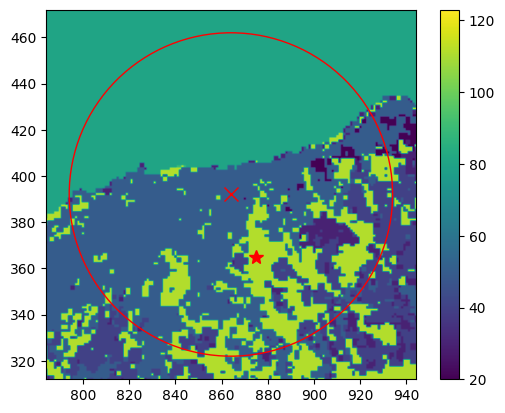

In [5]:
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio


# INPUTS TO SPECIFY
image_path = "example_for_coord_search.tif"  # Example from COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019 with 100m resolution
uncertainty_radius = (
    70  # For S2 1 pixel = 10m, so taking 70 pixels = 700m. 700^2 * pi = 1540 pixels
)
inner_radius = 10  # Radius in pixels to calculate area over which forested pixels should be counted, using sentinel 1px = 10
seed_random_point = 2020
seed_similarly_forested_point = 1111

# RUN FUNCTION
new_coord_based_on_forest_density(
    image_path,
    uncertainty_radius,
    inner_radius,
    seed_random_point,
    seed_similarly_forested_point,
)

## Pick random pixel in a n x n forest pixel window

This method first calculates for each pixel within a given radius around a middle point, whether the pixel is surrounded by a n x n window of forest pixels. If there are multiple pixels that fulfill this condition, one of them is chosen randomly.

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_6960/2072944151.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


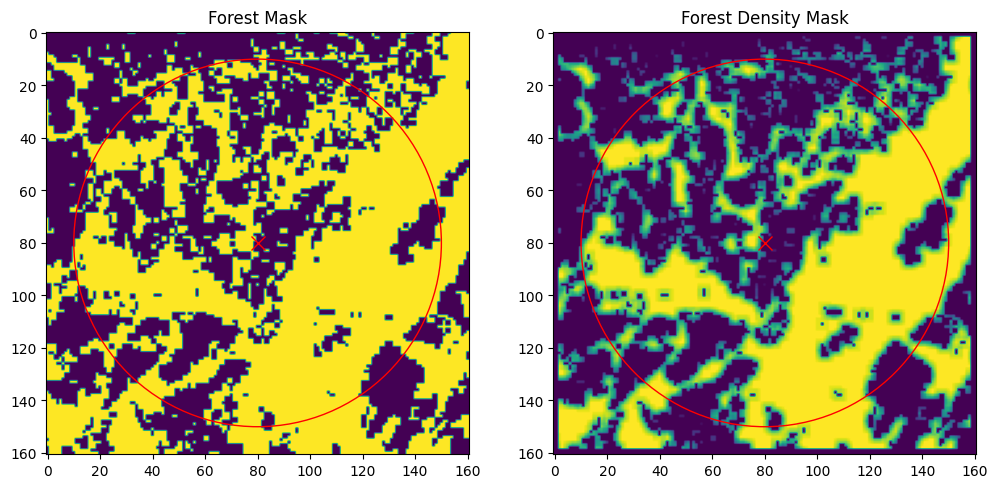

In [37]:
import re
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
from tqdm import tqdm

# Set inputs

image_path = "example_for_coord_search.tif"  # Example from COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019 with 100m resolution
radius_around_middle_point = (
    70  # For S2 1 pixel = 10m, so taking 70 pixels = 700m. 700^2 * pi = 1540 pixels
)
seed_random_point = 1
n_window = 5  # Pick uneven number to have a middle point

# Load the image
image = imageio.imread(image_path)

# Set all forest pixels to 1
forest_code = [111, 114, 115, 116, 121, 124, 125, 126, 200]
image[~np.isin(image, forest_code)] = 0  # Set all non-forest pixels to 0
image[np.isin(image, forest_code)] = 1  # Set all forest pixels to 1

# Pick a random point in that image
np.random.seed(seed_random_point)
middle_point = (
    np.random.randint(0, image.shape[0]),
    np.random.randint(0, image.shape[1]),
)

# Reduce image to the middle point plus its radius and some buffer pixels
# Define the buffer size
buffer_size = 10

# Define the indices for the slice
i_start = max(0, middle_point[0] - radius_around_middle_point - buffer_size)
i_end = min(
    image.shape[0], middle_point[0] + radius_around_middle_point + buffer_size + 1
)
j_start = max(0, middle_point[1] - radius_around_middle_point - buffer_size)
j_end = min(
    image.shape[1], middle_point[1] + radius_around_middle_point + buffer_size + 1
)

# Slice the image
reduced_image = image[i_start:i_end, j_start:j_end]

def produce_raster_with_forest_density(
    input_image,
    n_window,
):
    # Initialize an empty image
    out_image = np.zeros_like(input_image)

    # Loop over each pixel in the reduced image
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            # If the pixel is at the border, that is within the pixels defined by n_window, return a 0
            if (
                i < n_window // 2
                or i >= input_image.shape[0] - n_window // 2
                or j < n_window // 2
                or j >= input_image.shape[1] - n_window // 2
            ):
                out_image[i, j] = 0
            # If the pixel's value in input_image is 0, return 0
            elif input_image[i, j] == 0:
                out_image[i, j] = 0
            # If the pixel is not close to the border and has value 1, then calculate the sum of pixels around it within a n_window times n_window window
            else:
                window = input_image[
                    i - n_window // 2 : i + n_window // 2 + 1,
                    j - n_window // 2 : j + n_window // 2 + 1,
                ]
                out_image[i, j] = np.sum(window)

    return out_image


new_image = produce_raster_with_forest_density(reduced_image, n_window)

# plot the reduced and the new image side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
im = axs[0].imshow(reduced_image)

# Plot the middle point as a red cross with the radius around it in red
axs[0].plot(middle_point[1] - j_start, middle_point[0] - i_start, "rx", markersize=10)
circle = Circle(
    (middle_point[1] - j_start, middle_point[0] - i_start),
    radius=radius_around_middle_point,
    fill=False,
    color="r",
)
axs[0].add_patch(circle)

# Plot the second figure
im = axs[1].imshow(new_image)

# Plot the middle point as a red cross with the radius around it in red
axs[1].plot(middle_point[1] - j_start, middle_point[0] - i_start, "rx", markersize=10)
circle = Circle(
    (middle_point[1] - j_start, middle_point[0] - i_start),
    radius=radius_around_middle_point,
    fill=False,
    color="r",
)
axs[1].add_patch(circle)

# Add title to plot
axs[0].set_title("Forest Mask")
axs[1].set_title("Forest Density Mask")

# Show the plot
plt.show()

In [ ]:


# For each pixel within the radius around the middle point, calculate the number of forest pixels within n_window
# Initialize an empty list to store the number of forest pixels within n_window for each pixel within the radius around the middle point
forest_pixels = []

# Loop over each pixel within the radius around the middle point
for i in range(
    middle_point[0] - radius_around_middle_point,
    middle_point[0] + radius_around_middle_point,
):
    for j in range(
        middle_point[1] - radius_around_middle_point,
        middle_point[1] + radius_around_middle_point,
    ):
        # If the pixel is not a forested pixel, give it a zero value
        if image[i, j] != 1:
            forest_pixels.append(0)
        else:
            # Else, take the sum of all pixels within the n by n window specified by n_window
            window = image[
                max(0, i - (n_window - 1) // 2) : min(
                    image.shape[0], i + (n_window - 1) // 2 + 1
                ),
                max(0, j - (n_window - 1) // 2) : min(
                    image.shape[1], j + (n_window - 1) // 2 + 1
                ),
            ]
            forest_pixels.append(np.sum(window == 1))

# Convert the list to a numpy array and reshape it to have the same shape as the radius around the middle point
forest_pixels = np.array(forest_pixels).reshape(
    (2 * radius_around_middle_point + 1, 2 * radius_around_middle_point + 1)
)

# Filter for pixels that have the highest number of forest pixels within n_window
forest_pixels = pd.DataFrame(forest_pixels, columns=["x", "y", "count"])
forest_pixels = forest_pixels.sort_values(by="count", ascending=False)
forest_pixels = forest_pixels[forest_pixels["count"] == forest_pixels["count"].max()]

# Pick one of the pixels randomly
forest_pixels = forest_pixels.sample(n=1, random_state=seed_random_point)

# Create two plots, one showing the whole image and one zoomed in
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
im = axs[0].imshow(image)

# Plot the middle point as a red cross with the radius around it in red
axs[0].plot(middle_point[1], middle_point[0], "rx", markersize=10)
circle = Circle(
    (middle_point[1], middle_point[0]),
    radius=radius_around_middle_point,
    fill=False,
    color="r",
)
axs[0].add_patch(circle)

# Plot the newly calculated point as a red star
axs[0].plot(
    forest_pixels.iloc[0].loc["y"],
    forest_pixels.iloc[0].loc["x"],
    "r*",
    markersize=10,
)

# Set the limits of the x and y axes to be slightly larger than the circle's bounding box
left, right = max(0, middle_point[1] - radius_around_middle_point - 10), min(
    image.shape[1], middle_point[1] + radius_around_middle_point + 10
)
bottom, top = max(0, middle_point[0] - radius_around_middle_point - 10), min(
    image.shape[0], middle_point[0] + radius_around_middle_point + 10
)
axs[0].set_xlim(left, right)
axs[0].set_ylim(bottom, top)

# Add colorbar
sm = ScalarMappable(cmap=im.get_cmap(), norm=im.norm)
sm.set_array([])
fig.colorbar(sm, ax=axs[0])

# Plot the second figure
im = axs[1].imshow(image)

# Plot the middle point as a red cross and randomly selected as a red star
axs[1].plot(middle_point[1], middle_point[0], "rx", markersize=10)
axs[1].plot(
    forest_pixels.iloc[0].loc["y"],
    forest_pixels.iloc[0].loc["x"],
    "r*",
    markersize=10,
)

# Set the limits so that they focus on the two points
left, right = max(0, min(middle_point[1], forest_pixels.iloc[0].loc["y"]) - 10), min(
    image.shape[1], max(middle_point[1], forest_pixels.iloc[0].loc["y"]) + 10
)
bottom, top = max(0, min(middle_point[0], forest_pixels.iloc[0].loc["x"]) - 10), min(
    image.shape[0], max(middle_point[0], forest_pixels.iloc[0].loc["x"]) + 10
)
axs[1].set_xlim(left, right)

# Add colorbar
sm = ScalarMappable(cmap=im.get_cmap(), norm=im.norm)
sm.set_array([])
fig.colorbar(sm, ax=axs[1])

# Show the plot
plt.show()

## Extract all Forest Pixels

This approach does not correct any pixel values but extracts the coordinates of all forest pixels, for which then other data can be extracted for.

Advantage: Taking average across all forested areas is likely most representative than taking any randomly determined pixel.

Disadvantage: Blows up the number of time-series that have to be downloaded, creating a lot of overhead and slowing down the process.

In [10]:
# Function to extract all pixels of target value within a radius around a point (this approach blows up the number of time-series to be extracted)
import numpy as np

image_path = "example_for_coord_search.tif"


def find_pixels_within_radius(image_path, uncertainty_radius, seed_random_point):
    # Load the image
    image = imageio.imread(image_path)

    # Replace all different types of forests with the same value
    forest_code = [111, 114, 115, 116, 121, 124, 125, 126, 200]
    forest_number = 111
    image[np.isin(image, forest_code)] = forest_number

    # generate random x and y coordinates within the range of the image dimensions
    np.random.seed(seed_random_point)
    rand_x = np.random.randint(0, image.shape[1])
    rand_y = np.random.randint(0, image.shape[0])
    point = (rand_y, rand_x)

    pixels_within_radius = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            distance = np.sqrt((i - point[0]) ** 2 + (j - point[1]) ** 2)
            if distance <= uncertainty_radius and image[i, j] == forest_number:
                pixels_within_radius.append((i, j))
    return pixels_within_radius

In [11]:
# INPUTS TO SPECIFY
image_path = "example_for_coord_search.tif"  # Example from COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019 with 100m resolution
uncertainty_radius = (
    70  # For S2 1 pixel = 10m, so taking 70 pixels = 700m. 70^2 * pi = 15'400 pixels in total
)
inner_radius = 10  # Radius in pixels to calculate area over which forested pixels should be counted, using sentinel 1px = 10
seed_random_point = 2020
seed_similarly_forested_point = 1111

all_pix = find_pixels_within_radius(image_path, uncertainty_radius, seed_random_point)
print(f"Number of extracted forest pixels: {len(all_pix)}")

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_16418/1801924393.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Number of extracted forest pixels: 2615
